<div class="alert alert-danger">

<h1>Take notice!</h1>
<ul>
    <li>Make sure you are working with a copy and not the original notebook file</li>
    <li>This class will be recorded</li>
</ul>
    
</div>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Take-notice!" data-toc-modified-id="Take-notice!-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Take notice!</a></span></li><li><span><a href="#Point-Pattern-Analysis" data-toc-modified-id="Point-Pattern-Analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Point Pattern Analysis</a></span><ul class="toc-item"><li><span><a href="#Libraries" data-toc-modified-id="Libraries-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Libraries</a></span></li><li><span><a href="#Crime-Data" data-toc-modified-id="Crime-Data-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Crime Data</a></span></li><li><span><a href="#Heat-maps" data-toc-modified-id="Heat-maps-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Heat maps</a></span></li><li><span><a href="#Interactive-exploration" data-toc-modified-id="Interactive-exploration-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Interactive exploration</a></span></li><li><span><a href="#Seaborn-Plots" data-toc-modified-id="Seaborn-Plots-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Seaborn Plots</a></span><ul class="toc-item"><li><span><a href="#Visualizing-statistical-relationships" data-toc-modified-id="Visualizing-statistical-relationships-2.5.1"><span class="toc-item-num">2.5.1&nbsp;&nbsp;</span>Visualizing statistical relationships</a></span></li><li><span><a href="#Seaborn-themes" data-toc-modified-id="Seaborn-themes-2.5.2"><span class="toc-item-num">2.5.2&nbsp;&nbsp;</span>Seaborn themes</a></span></li><li><span><a href="#Choosing-colors" data-toc-modified-id="Choosing-colors-2.5.3"><span class="toc-item-num">2.5.3&nbsp;&nbsp;</span>Choosing colors</a></span></li><li><span><a href="#Filter-by-location-(e.g.-Hollywood)" data-toc-modified-id="Filter-by-location-(e.g.-Hollywood)-2.5.4"><span class="toc-item-num">2.5.4&nbsp;&nbsp;</span>Filter by location (e.g. Hollywood)</a></span></li></ul></li><li><span><a href="#Joint-plots" data-toc-modified-id="Joint-plots-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Joint plots</a></span></li><li><span><a href="#Heatmap" data-toc-modified-id="Heatmap-2.7"><span class="toc-item-num">2.7&nbsp;&nbsp;</span>Heatmap</a></span></li><li><span><a href="#Centrography" data-toc-modified-id="Centrography-2.8"><span class="toc-item-num">2.8&nbsp;&nbsp;</span>Centrography</a></span><ul class="toc-item"><li><span><a href="#Central-tendency" data-toc-modified-id="Central-tendency-2.8.1"><span class="toc-item-num">2.8.1&nbsp;&nbsp;</span>Central tendency</a></span></li><li><span><a href="#Dispersion-and-Orientation" data-toc-modified-id="Dispersion-and-Orientation-2.8.2"><span class="toc-item-num">2.8.2&nbsp;&nbsp;</span>Dispersion and Orientation</a></span></li></ul></li></ul></li></ul></div>


# Point Pattern Analysis
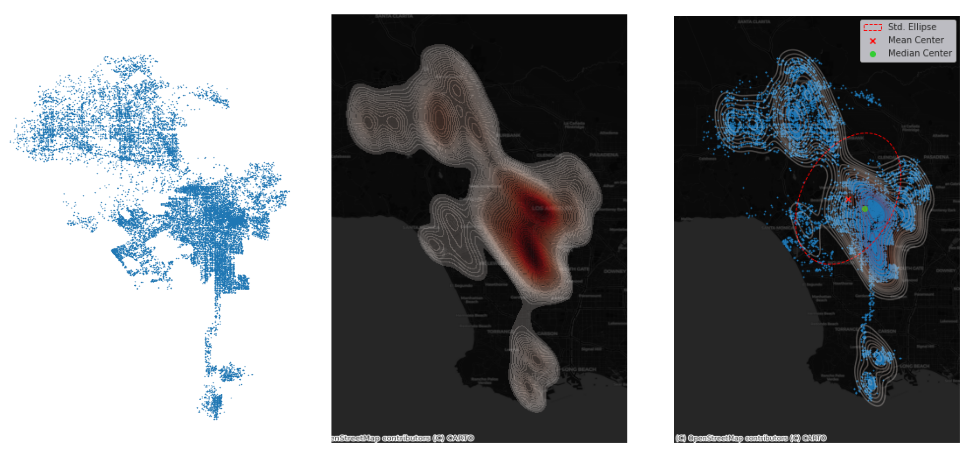

In our previous lab, we looked at spatial autocorrelation as a means to extract statistical significance in our datas spatial clustering tendencies. We did so by summarizing point data by small geographic boundaries, spatially joining arrest data to census block groups. But what if we did not care to summarize data by geographic boundaries, but rather simply look at the the location of points to deduct statistical spatial patterns? In this lab, we look at various methods to conduct point pattern analysis, while also introducing interactive notebook widgets to explore our data.

## Libraries

In [1]:
# the usuals
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import contextily as ctx
from sodapy import Socrata

# new for data viz
import seaborn as sns

# to explore point patterns
from pointpats import centrography
from matplotlib.patches import Ellipse
import numpy

## Crime Data

We will use crime data from the LAPD for this lab. 
- [Crime Data from 2020 to Present](https://data.lacity.org/Public-Safety/Crime-Data-from-2020-to-Present/2nrs-mtv8)


In [2]:
# connect to the data portal
client = Socrata("data.lacity.org", None)

results = client.get("2nrs-mtv8", 
                     limit=50000,
                     where = "date_rptd >= '2020-09-01T00:00:00'",
                     order='date_rptd desc')

# Convert to pandas DataFrame
df = pd.DataFrame.from_records(results)

In [3]:
df.shape

(43187, 28)

In [4]:
# convert pandas dataframe to geodataframe
df = gpd.GeoDataFrame(df, 
                     crs='EPSG:4326',
                     geometry=gpd.points_from_xy(df.lon, df.lat))

In [5]:
# convert lat/lon to floats
df.lon = df.lon.astype('float')
df.lat = df.lat.astype('float')
df.vict_age = df.vict_age.astype('int')

In [6]:
# drop the unmapped rows
df.drop(df[df.lon==0].index,inplace=True)

In [7]:
# filter columns
df=df[['date_rptd','area_name','vict_age','vict_sex','vict_descent','crm_cd_desc','geometry']]

In [8]:
# rename columns
df.columns = ['date','area_name','age','sex','race','crime','geometry']

In [9]:
# project to web mercator
df=df.to_crs('EPSG:3857')

In [10]:
# drop rows with null values
df = df.dropna()

In [11]:
# drop rows where age == 0
df = df[df.age!=0]

In [12]:
df.shape

(32248, 7)

In [13]:
df.sample(20)

,date,area_name,age,sex,race,crime,geometry
593,2020-11-22T00:00:00.000,Central,49,F,B,BURGLARY FROM VEHICLE,POINT (-13163418.467 4034792.290)
5984,2020-11-11T00:00:00.000,Foothill,27,F,W,"THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LI...",POINT (-13178257.355 4057317.555)
5130,2020-11-13T00:00:00.000,Topanga,63,M,B,BATTERY - SIMPLE ASSAULT,POINT (-13205085.352 4051423.054)
42272,2020-09-02T00:00:00.000,Rampart,33,M,H,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",POINT (-13169040.101 4039051.859)
7834,2020-11-08T00:00:00.000,Devonshire,65,F,H,THEFT PLAIN - PETTY ($950 & UNDER),POINT (-13191615.694 4063928.961)
39270,2020-09-08T00:00:00.000,Pacific,29,M,B,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",POINT (-13188765.915 4027902.415)
5563,2020-11-12T00:00:00.000,Pacific,61,F,W,BURGLARY,POINT (-13187942.151 4027351.942)
11114,2020-11-01T00:00:00.000,Hollywood,45,F,W,VIOLATION OF RESTRAINING ORDER,POINT (-13173270.242 4043165.132)
11901,2020-10-31T00:00:00.000,Mission,5,F,H,CHILD NEGLECT (SEE 300 W.I.C.),POINT (-13184847.469 4070881.157)
37394,2020-09-12T00:00:00.000,Pacific,28,F,H,BATTERY - SIMPLE ASSAULT,POINT (-13181619.204 4030883.487)


## Heat maps
This lab will focus on visualing point densities in a variety of ways. Before we begin, let's have a look at the arrest data in its "raw" format, by simply creating a point map: a single point for its given location on a grid.

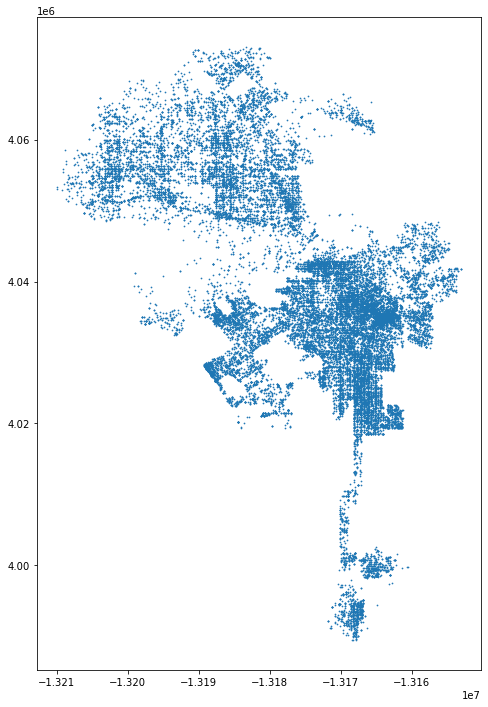

In [14]:
df.plot(figsize=(12,12),
             markersize=0.5)

The resulting plot tells us a lot about the data we have imported into the notebook. The overall shape, if you are familiar with Los Angeles, gives a sense of the physical space that is defined by its city boundary. Even in the absence of basemaps, satellite imagery, and other layers of information, the divided city of angels comes to life: from the "valley" in the northwest, the empty white space that is the Santa Monica Mountains on the west, the blob in center right that defines the contours of downtown Los Angeles, accentuated by the pathway to the port heading south towards Long Beach. And through this cacophony of points, we can begin to detect point patterns that delineate streets and certain neighborhoods appear to be more concentrated than others. 

While the visual interpretation can be rich and informative, let's begin a statistical exploration of the point patterns.

## Interactive exploration

Jupyter notebooks is a unique coding platform that allows you to mix documentation (markdown cells) with interactive code cells. There is, however, another level of interactivity that can be developed. By "interactive" we mean to say that it utilizes the interactive features of the web, allowing users to use dropdowns and sliders to manipulate the output.

The presence of these interactive widgets allows us to explore the data without the need to consistently modify code cells to change parameters. It is, in a sense, a snazzy and useful utility to your notebook.

To add interactivity to your cell output, the following steps are required:

- import the interact library
- create a function with at least one argument
- if the argument is numeric, a slider will be generated
- if the argument is categorical, provide a list of values to generate a dropdown menu

For this section, we will build an interactive map of Los Angeles showing the location of arrests by arrest type. A dropdown menu will allow you to change the crime type and update the map.

In [15]:
# import that interact library
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In order to create a dropdown of crime types, we need to create a list of them.

In [16]:
df.crime.value_counts()

BATTERY - SIMPLE ASSAULT                                   3575
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT             2826
BURGLARY FROM VEHICLE                                      2325
INTIMATE PARTNER - SIMPLE ASSAULT                          2323
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)    2085
                                                           ... 
DOCUMENT WORTHLESS ($200 & UNDER)                             1
COUNTERFEIT                                                   1
MANSLAUGHTER, NEGLIGENT                                       1
THEFT, COIN MACHINE - ATTEMPT                                 1
THEFT, COIN MACHINE - PETTY ($950 & UNDER)                    1
Name: crime, Length: 108, dtype: int64

That's quite a lot of categories. Let's narrow it down to the top 50, and put it in a list variable `top_50_crimes`.

In [17]:
# get the top 50 crime types into a list
top_50_crimes = df.crime.value_counts().head(50).index.tolist()
top_50_crimes

['BATTERY - SIMPLE ASSAULT',
 'ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT',
 'BURGLARY FROM VEHICLE',
 'INTIMATE PARTNER - SIMPLE ASSAULT',
 'VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)',
 'BURGLARY',
 'THEFT PLAIN - PETTY ($950 & UNDER)',
 'THEFT OF IDENTITY',
 'ROBBERY',
 'VANDALISM - MISDEAMEANOR ($399 OR UNDER)',
 'THEFT FROM MOTOR VEHICLE - GRAND ($400 AND OVER)',
 'THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)',
 'THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD',
 'CRIMINAL THREATS - NO WEAPON DISPLAYED',
 'BRANDISH WEAPON',
 'INTIMATE PARTNER - AGGRAVATED ASSAULT',
 'VIOLATION OF RESTRAINING ORDER',
 'BIKE - STOLEN',
 'TRESPASSING',
 'LETTERS, LEWD  -  TELEPHONE CALLS, LEWD',
 'VIOLATION OF COURT ORDER',
 'BUNCO, GRAND THEFT',
 'SHOPLIFTING - PETTY THEFT ($950 & UNDER)',
 'OTHER MISCELLANEOUS CRIME',
 'BATTERY WITH SEXUAL CONTACT',
 'ATTEMPTED ROBBERY',
 'OTHER ASSAULT',
 'RAPE, FORCIBLE',
 'CHILD ABUSE (PHYSICAL) - SIMPLE ASSAULT',
 'THEFT, PERSON',
 

If we were then to produce a slice of the data for a single crime type:

In [18]:
df[df.crime == 'BATTERY - SIMPLE ASSAULT'].head()

,date,area_name,age,sex,race,crime,geometry
10,2020-11-23T00:00:00.000,Van Nuys,30,F,H,BATTERY - SIMPLE ASSAULT,POINT (-13185916.136 4049136.058)
23,2020-11-23T00:00:00.000,Van Nuys,19,F,W,BATTERY - SIMPLE ASSAULT,POINT (-13183099.753 4049189.864)
63,2020-11-23T00:00:00.000,Van Nuys,73,M,W,BATTERY - SIMPLE ASSAULT,POINT (-13183099.753 4049189.864)
117,2020-11-23T00:00:00.000,Rampart,25,F,W,BATTERY - SIMPLE ASSAULT,POINT (-13167325.781 4034160.880)
122,2020-11-23T00:00:00.000,Central,44,F,W,BATTERY - SIMPLE ASSAULT,POINT (-13164052.988 4034684.813)


Let's put this all together in a single cell, adding a map output:

,date,area_name,age,sex,race,crime,geometry
10,2020-11-23T00:00:00.000,Van Nuys,30,F,H,BATTERY - SIMPLE ASSAULT,POINT (-13185916.136 4049136.058)
23,2020-11-23T00:00:00.000,Van Nuys,19,F,W,BATTERY - SIMPLE ASSAULT,POINT (-13183099.753 4049189.864)
63,2020-11-23T00:00:00.000,Van Nuys,73,M,W,BATTERY - SIMPLE ASSAULT,POINT (-13183099.753 4049189.864)
117,2020-11-23T00:00:00.000,Rampart,25,F,W,BATTERY - SIMPLE ASSAULT,POINT (-13167325.781 4034160.880)
122,2020-11-23T00:00:00.000,Central,44,F,W,BATTERY - SIMPLE ASSAULT,POINT (-13164052.988 4034684.813)


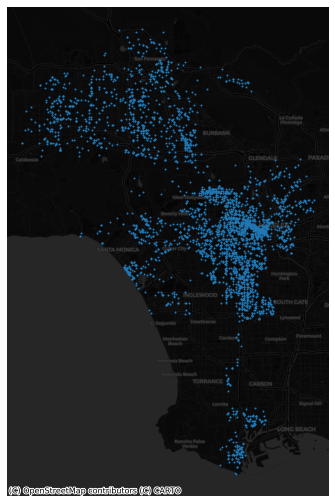

In [19]:
# table
display(df[df.crime == 'BATTERY - SIMPLE ASSAULT'].head()) 

# map
ax = df[df.crime == 'BATTERY - SIMPLE ASSAULT'].plot(figsize=(9,9), markersize=1)

# axis
ax.axis('off')

# basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.DarkMatter)

Now that we have a desired output based on code in a single cell, create a function. Notice how `crime` is a required argument.

In [20]:
# create a function
def crime_by(crime='BATTERY - SIMPLE ASSAULT'):
    # table
    display(df[df.crime == crime].head()) 
    
    # map
    ax = df[df.crime == crime].plot(figsize=(9,9), markersize=2)
    
    # axis
    ax.axis('off')
    
    # basemap
    ctx.add_basemap(ax,source=ctx.providers.CartoDB.DarkMatter)

,date,area_name,age,sex,race,crime,geometry
6,2020-11-23T00:00:00.000,Central,33,F,H,BURGLARY,POINT (-13162984.321 4036794.223)
29,2020-11-23T00:00:00.000,Pacific,55,F,W,BURGLARY,POINT (-13185960.664 4023418.846)
36,2020-11-23T00:00:00.000,77th Street,30,F,B,BURGLARY,POINT (-13170231.220 4021969.446)
106,2020-11-23T00:00:00.000,Van Nuys,56,F,O,BURGLARY,POINT (-13182799.190 4049983.538)
133,2020-11-23T00:00:00.000,Hollywood,42,M,H,BURGLARY,POINT (-13172379.686 4041968.635)


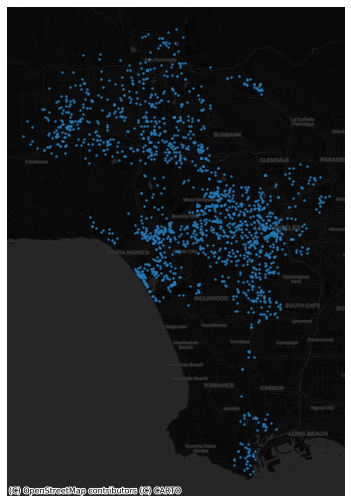

In [21]:
# call the function for a different crime type
crime_by(crime = 'BURGLARY')

Next, we use an interactive feature to create a drop down for our function.

In [22]:
# to make this function interactive
@interact

# function argument will become interactive
def arrests_by(crime=top_50_crimes):
    # table
    display(df[df.crime == crime].head()) 

    # map
    ax = df[df.crime == crime].plot(figsize=(9,9), markersize=10)
    
    # axis
    ax.axis('off')

    # basemap
    ctx.add_basemap(ax,source=ctx.providers.CartoDB.DarkMatter)

interactive(children=(Dropdown(description='crime', options=('BATTERY - SIMPLE ASSAULT', 'ASSAULT WITH DEADLY …

<div class="alert alert-info">
Now it's your turn! Create an interactive map with a drop down for a different column (e.g. area_name, race, sex).
    
Extra challenge: Create an interactive map with multiple dropdowns.
</div>

In [25]:
df.race.unique().tolist()

['H',
 'W',
 'B',
 'X',
 'O',
 'A',
 'K',
 'F',
 'I',
 'C',
 'J',
 'S',
 'V',
 'Z',
 'P',
 'D',
 'G',
 'U']

In [24]:
# to make this function interactive
@interact

# function argument will become interactive
def arrests_by(crime=top_50_crimes,
               area=df.area_name.unique().tolist()):
    # table
    display(df[(df.crime == crime)&(df.area_name==area)].head()) 

    # map
    ax = df[(df.crime == crime)&(df.area_name==area)].plot(figsize=(9,9), markersize=10)
    
    # axis
    ax.axis('off')

    # basemap
    ctx.add_basemap(ax,source=ctx.providers.CartoDB.DarkMatter)

interactive(children=(Dropdown(description='crime', options=('BATTERY - SIMPLE ASSAULT', 'ASSAULT WITH DEADLY …

## Seaborn Plots
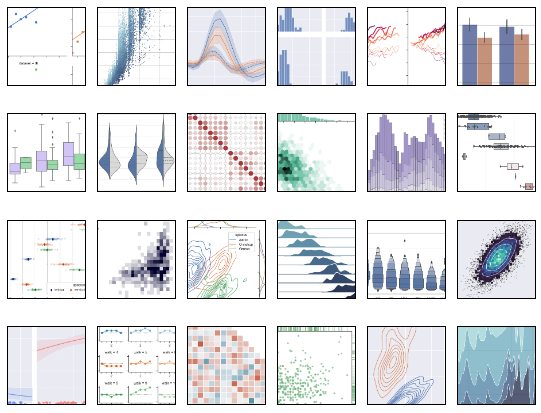
We have explored data vizualization through [matplotlib](https://matplotlib.org/) (static images) and [plotly](https://plot.ly/python/) (interactive javascript). We will now look at [seaborn](https://seaborn.pydata.org/), the natural third wheel of the python visualization trifecta. Seaborn is favored by statisticians for its advanced capabilities, and by designers for its more flexible and intuitive graphical features.

> Seaborn is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics.

-https://seaborn.pydata.org/

In [26]:
# we'll work in Web Mercator
df = df.to_crs('EPSG:3857')

In [27]:
# seaborn needs an x and y column so let's extract it from the geometry field
df['x'] = df.geometry.x
df['y'] = df.geometry.y

In [28]:
df.head()

,date,area_name,age,sex,race,crime,geometry,x,y
3,2020-11-23T00:00:00.000,Hollenbeck,19,M,H,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",POINT (-13154624.227 4040194.286),-1.315462e+07,4.040194e+06
6,2020-11-23T00:00:00.000,Central,33,F,H,BURGLARY,POINT (-13162984.321 4036794.223),-1.316298e+07,4.036794e+06
8,2020-11-23T00:00:00.000,Hollywood,35,M,W,THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER),POINT (-13169919.525 4042963.467),-1.316992e+07,4.042963e+06
10,2020-11-23T00:00:00.000,Van Nuys,30,F,H,BATTERY - SIMPLE ASSAULT,POINT (-13185916.136 4049136.058),-1.318592e+07,4.049136e+06
11,2020-11-23T00:00:00.000,Mission,23,F,H,INTIMATE PARTNER - SIMPLE ASSAULT,POINT (-13181852.974 4060346.743),-1.318185e+07,4.060347e+06


### Visualizing statistical relationships

- https://seaborn.pydata.org/tutorial/relational.html

In [29]:
# create a subset
data_mini = df[df.race.isin(['H','B'])]

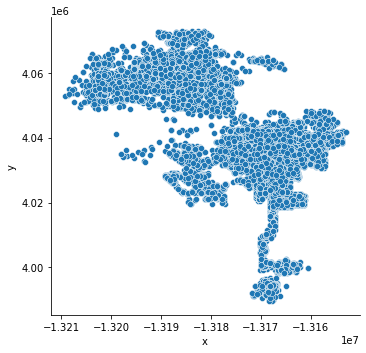

In [30]:
# scatterplot
sns.relplot(data=data_mini,
            x='x', 
            y='y')

### Seaborn themes

- https://seaborn.pydata.org/tutorial/aesthetics.html

You can set different themes by choosing one of the following:
- darkgrid
- whitegrid
- dark
- white
- ticks

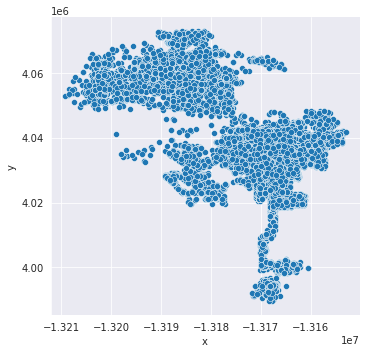

In [31]:
# seaborn comes with themes to make them prettier
sns.set_style('darkgrid')

# scatterplot 
sns.relplot(data=data_mini,
            x='x', 
            y='y')

In [32]:
@interact
def sns_styles(style=['darkgrid', 'whitegrid', 'dark', 'white', 'ticks']):
    # seaborn comes with themes to make them prettier
    sns.set_style(style)

    # scatterplot 
    sns.relplot(data=data_mini,
                x='x', 
                y='y')

interactive(children=(Dropdown(description='style', options=('darkgrid', 'whitegrid', 'dark', 'white', 'ticks'…

### Choosing colors
Here is a list of valid palette values:

In [33]:
color_list=['Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r']

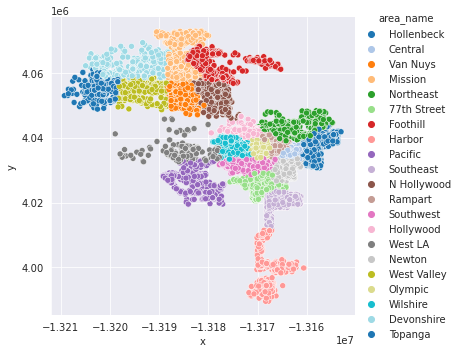

In [34]:
# scatterplot colored by area
sns.relplot(data=data_mini,
            x='x', 
            y='y',
            hue='area_name',
            palette='tab20')

In [35]:
@interact
def crime_areas(palette=color_list):
# scatterplot colored by area
    sns.relplot(data=data_mini,
                x='x', 
                y='y',
                hue='area_name',
                palette=palette)

interactive(children=(Dropdown(description='palette', options=('Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG…

### Filter by location (e.g. Hollywood)

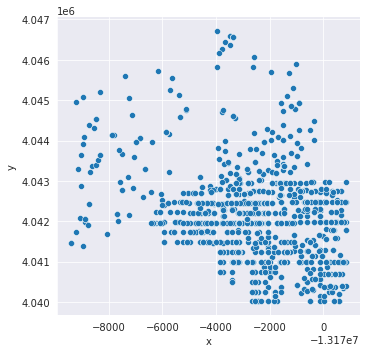

In [36]:
sns.relplot(data=df[df['area_name']=='Hollywood'],
            x='x', 
            y='y')

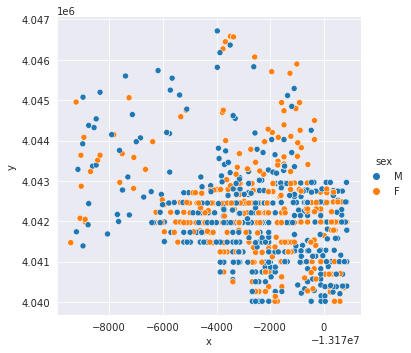

In [37]:
# color by categorical column
sns.relplot(data=df[df['area_name']=='Hollywood'],
            x='x', 
            y='y',
            hue='sex')

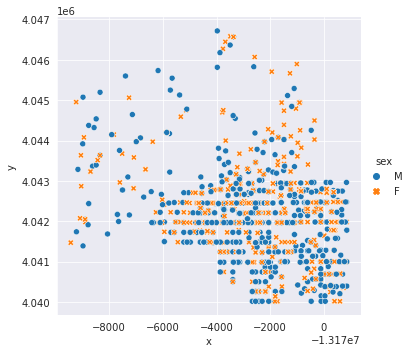

In [38]:
# style markers
sns.relplot(data=df[df['area_name']=='Hollywood'],
            x='x', 
            y='y',
            hue='sex',
            style='sex')

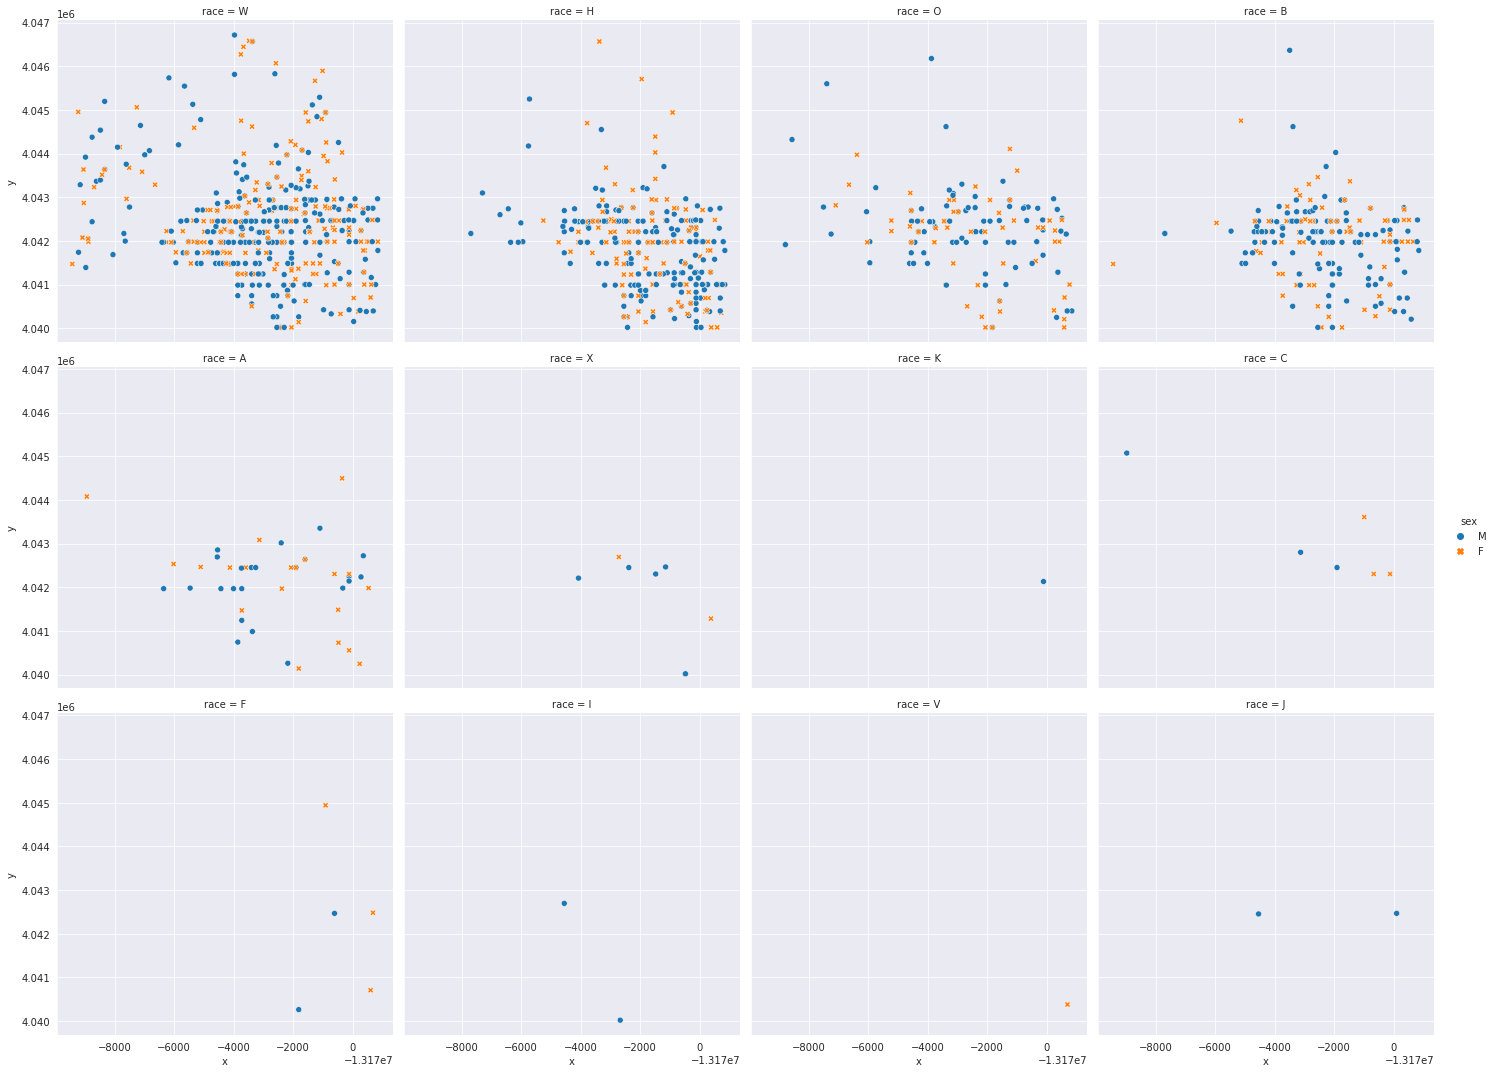

In [39]:
# create multiple plots at once with facets
sns.relplot(data=df[df['area_name']=='Hollywood'],
            x='x', 
            y='y',
            hue='sex',
            style='sex',
            col='race',
            col_wrap=4)

## Joint plots

- https://seaborn.pydata.org/generated/seaborn.jointplot.html

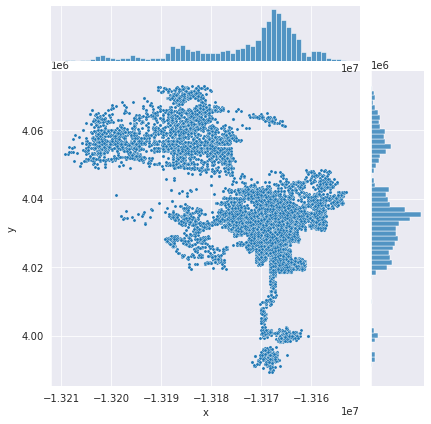

In [40]:
# scatterplot with edges
g = sns.jointplot(data = data_mini,
                  x='x', 
                  y='y',
                  s=10)

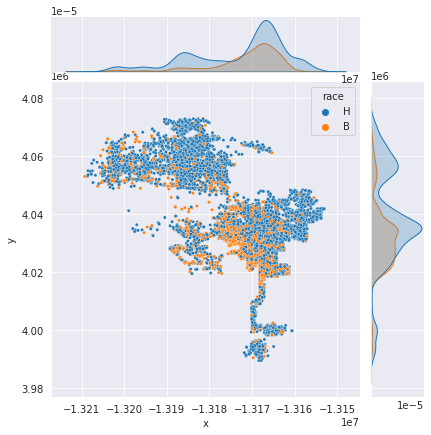

In [41]:
# color code by race
g = sns.jointplot(data = data_mini,
                  x='x', 
                  y='y',
                  hue='race',
                  s=10)

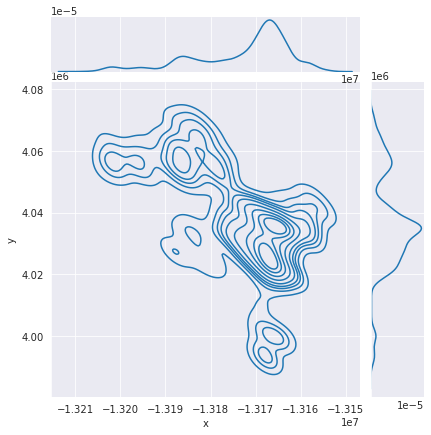

In [42]:
# kde plot
sns.jointplot(data = data_mini,
              x='x', 
              y='y', 
              kind='kde')

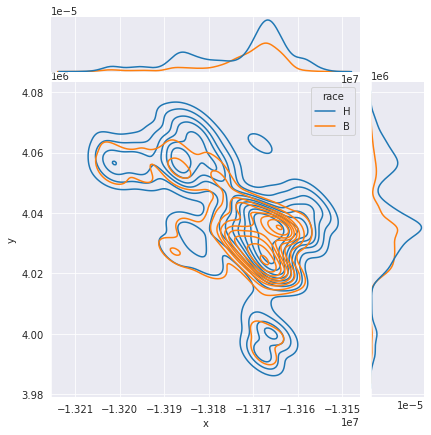

In [43]:
# multiple kde plots by race
sns.jointplot(data = data_mini,
              x='x', 
              y='y', 
              kind='kde',
              hue='race')

## Heatmap

The `kde` jointplot is utilized in maps typically referred to as "heat maps." We can use the seaborn `kdeplot` function in conjunction with our usual subplots and contextily basemaps.

- https://seaborn.pydata.org/generated/seaborn.kdeplot.html

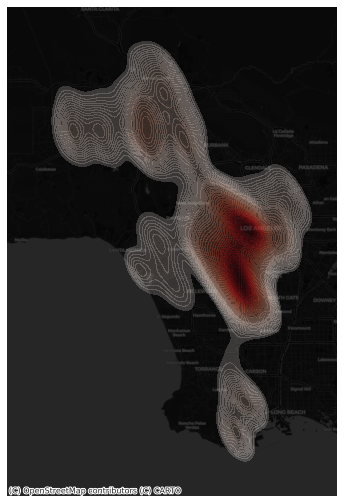

In [44]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))

# kdeplot, i.e. heat map
sns.kdeplot(x = data_mini.x, 
            y = data_mini.y,
            n_levels=50, 
            shade=True,
            thresh=0.05,
            alpha=0.2, 
            cmap='Reds')

# axes
ax.axis('off')

# basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.DarkMatter)

## Centrography

Centrography refers to a set of descriptive statistics that provide summary descriptions of point patterns. Here, we look at two features: **central tendency** using mean center and median center and **dispersion and orientation** using a standard deviational ellipse.

### Central tendency

Calculating the mean and median centers of point data allow us to visualize the global "center" of the point dataset. While this in itself may not be that informative, creating slices of your data can reveal meaningful insights on the central tendencies of different aspects of the data. For example, the statistical central locations may differ by crime type, allowing one to question why this may be the case.

In [45]:
# compute the mean and median centers
mean_center = centrography.mean_center(df[['x','y']])
med_center = centrography.euclidean_median(df[['x','y']])

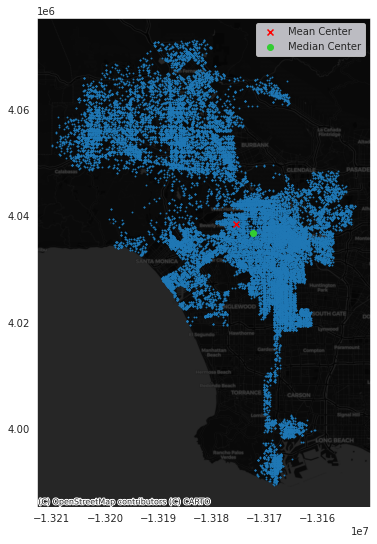

In [46]:
# set the style without grid lines
sns.set_style('dark')

# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))

# Plot points
ax.scatter(df['x'], df['y'], s=0.75)
ax.scatter(*mean_center, color='red', marker='x', label='Mean Center')
ax.scatter(*med_center, color='limegreen', marker='o', label='Median Center')

ax.legend()

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.DarkMatter)
# Display
plt.show()

### Dispersion and Orientation

In addition to the center mean and median, the directional distribution of the points can reveal additional insights to how the data is dispersed over space. This can be visualized using a standard deviational ellipse, where the standard deviations are calculated for the x and y coordinates from the mean center. The ellipse is rotated based on the orientation of the data.

In [47]:
major, minor, rotation = centrography.ellipse(df[['x','y']])

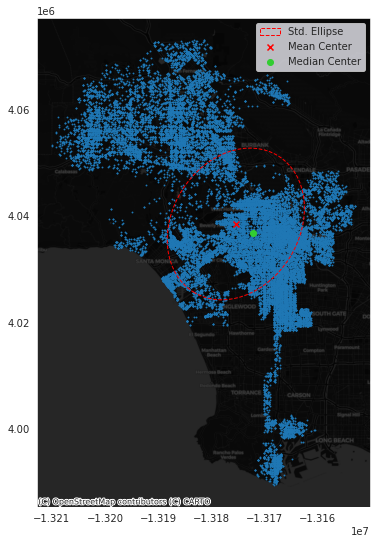

In [48]:
# set the style without grid lines
sns.set_style('dark')

# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))

# Plot points
ax.scatter(df['x'], df['y'], s=0.75)
ax.scatter(*mean_center, color='red', marker='x', label='Mean Center')
ax.scatter(*med_center, color='limegreen', marker='o', label='Median Center')

# Construct the standard ellipse using matplotlib
ellipse = Ellipse(xy=mean_center, # center the ellipse on our mean center
                  width=major*2, # centrography.ellipse only gives half the axis
                  height=minor*2, 
                  angle = numpy.rad2deg(rotation), # Angles for this are in degrees, not radians
                  facecolor='none', 
                  edgecolor='red', linestyle='--',
                  label='Std. Ellipse')

ax.add_patch(ellipse)

ax.legend()

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.DarkMatter)

# Display
plt.show()

Now let's put it all together. The following function does:

- a dropdown to select different race categories
- crime locations
- center mean and median
- standard deviational ellipsoid
- kde plot

In [49]:
@interact
def crime_ellipse(race=df.race.unique().tolist()):
    # filter the data by race
    crime_filtered = df[df.race == race]

    # mean center and median
    mean_center = centrography.mean_center(crime_filtered[['x','y']])
    med_center = centrography.euclidean_median(crime_filtered[['x','y']])

    # standard ellipse
    major, minor, rotation = centrography.ellipse(crime_filtered[['x','y']])

    # Set up figure and axis
    f, ax = plt.subplots(1, figsize=(9, 9))

    # plot arrest points
    ax.scatter(crime_filtered['x'], crime_filtered['y'], s=0.75)

    # add the mean and median center points
    ax.scatter(*mean_center, color='red', marker='x', label='Mean Center')
    ax.scatter(*med_center, color='limegreen', marker='o', label='Median Center')

    # heatmap
    sns.kdeplot(x = crime_filtered.geometry.x, 
                y = crime_filtered.geometry.y,
                n_levels=20, 
                shade=False,
                thresh=0.1,
                alpha=0.3, 
                cmap='Reds', 
                ax=ax)

    # Construct the standard ellipse using matplotlib
    ellipse = Ellipse(xy=mean_center, # center the ellipse on our mean center
                      width=major*2, # centrography.ellipse db_filtered
                      height=minor*2, 
                      angle = numpy.rad2deg(rotation), # Angles for this are in degrees, not radians
                      facecolor='none', 
                      edgecolor='red', linestyle='--',
                      label='Std. Ellipse')

    ax.add_patch(ellipse)

    ax.legend()

    ax.axis('Off')

    ax.set_title(str(len(crime_filtered)) + ' incidents of crime with reported victim descent "' + race + '"')

    # add a basemap
    ctx.add_basemap(ax,source=ctx.providers.CartoDB.DarkMatter)
    # Display
    plt.show()

interactive(children=(Dropdown(description='race', options=('H', 'W', 'B', 'X', 'O', 'A', 'K', 'F', 'I', 'C', …

In [50]:
@interact
def crime_ellipse(race=df.race.unique().tolist(),
                  area=df.area_name.unique().tolist()):
    # filter the data by race
    crime_filtered = df[(df.race == race)&(df.area_name==area)]

    # mean center and median
    mean_center = centrography.mean_center(crime_filtered[['x','y']])
    med_center = centrography.euclidean_median(crime_filtered[['x','y']])

    # standard ellipse
    major, minor, rotation = centrography.ellipse(crime_filtered[['x','y']])

    # Set up figure and axis
    f, ax = plt.subplots(1, figsize=(9, 9))

    # plot arrest points
    ax.scatter(crime_filtered['x'], crime_filtered['y'], s=0.75)

    # add the mean and median center points
    ax.scatter(*mean_center, color='red', marker='x', label='Mean Center')
    ax.scatter(*med_center, color='limegreen', marker='o', label='Median Center')

    # heatmap
    sns.kdeplot(x = crime_filtered.geometry.x, 
                y = crime_filtered.geometry.y,
                n_levels=20, 
                shade=False,
                thresh=0.1,
                alpha=0.3, 
                cmap='Reds', 
                ax=ax)

    # Construct the standard ellipse using matplotlib
    ellipse = Ellipse(xy=mean_center, # center the ellipse on our mean center
                      width=major*2, # centrography.ellipse db_filtered
                      height=minor*2, 
                      angle = numpy.rad2deg(rotation), # Angles for this are in degrees, not radians
                      facecolor='none', 
                      edgecolor='red', linestyle='--',
                      label='Std. Ellipse')

    ax.add_patch(ellipse)

    ax.legend()

    ax.axis('Off')

    ax.set_title(str(len(crime_filtered)) + ' incidents of crime with reported victim descent "' + race + '"')

    # add a basemap
    ctx.add_basemap(ax,source=ctx.providers.CartoDB.DarkMatter)
    # Display
    plt.show()

interactive(children=(Dropdown(description='race', options=('H', 'W', 'B', 'X', 'O', 'A', 'K', 'F', 'I', 'C', …

<div class="alert alert-info">
Now it's your turn! Add a dropdown to the function above that allows you to filter the map for race AND area. (hint: copy and paste the cell above)
</div>